In [46]:
from PIL import Image
import os
import numpy as np
import pandas as pd
import csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

In [2]:
alex_images_path = "Alex_Kelly_Pics/Alex"
kelly_images_path = "Alex_Kelly_Pics/Kelly"
test_images_path = "Alex_Kelly_Pics/TestSet"
image_labels_path = "Kelly_and_Alex_Image_Labels - Sheet1.csv"

In [5]:
def sorted_image_names(path):
    return sorted(os.listdir(path), key=lambda x: int(''.join(filter(str.isdigit, x))))

In [7]:
alex_image_names = sorted_image_names(alex_images_path)
kelly_image_names = sorted_image_names(kelly_images_path)
test_image_names = sorted_image_names(test_images_path)

image_names = alex_image_names + kelly_image_names

In [9]:
labels = pd.read_csv(image_labels_path)
le = LabelEncoder().fit(labels["Landscape"])
labels["Landscape"] = le.transform(labels["Landscape"])
labels

,image_name,Human,Castle,Indoors,Landscape,Woman,Daytime,Children,Sunset,Flower,Animal,Building,Mask,Gray-Hair,Fire,Food_drink
0,Alex-Image01.png,1,0,0,2,0,1,1,0,0,1,0,0,0,0,0
1,Alex-Image02.png,1,0,0,2,0,1,1,0,0,0,1,0,0,0,0
2,Alex-Image03.png,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,Alex-Image04.png,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
4,Alex-Image05.png,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,Kelly-Image225.png,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0
481,Kelly-Image226.png,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
482,Kelly-Image227.png,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0
483,Kelly-Image228.png,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [11]:
labels['Photographer'] = labels['image_name'].str.split('-', n = 1).str[0]

In [13]:
le = LabelEncoder().fit(labels["Photographer"])
labels["Photographer"] = le.transform(labels["Photographer"])

In [15]:
labels

,image_name,Human,Castle,Indoors,Landscape,Woman,Daytime,Children,Sunset,Flower,Animal,Building,Mask,Gray-Hair,Fire,Food_drink,Photographer
0,Alex-Image01.png,1,0,0,2,0,1,1,0,0,1,0,0,0,0,0,0
1,Alex-Image02.png,1,0,0,2,0,1,1,0,0,0,1,0,0,0,0,0
2,Alex-Image03.png,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,Alex-Image04.png,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,Alex-Image05.png,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,Kelly-Image225.png,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1
481,Kelly-Image226.png,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1
482,Kelly-Image227.png,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1
483,Kelly-Image228.png,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1


In [17]:
def get_largest_size(folder):
    biggest_image = [0, 0]
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img.size[0] > biggest_image[0]: 
            biggest_image[0] = img.size[0]
        if img.size[1] > biggest_image[1]:
            biggest_image[1] = img.size[1]
    return biggest_image

In [19]:
alex_im_size = get_largest_size(alex_images_path)
kelly_im_size = get_largest_size(kelly_images_path)
test_im_size = get_largest_size(test_images_path)

print("Max Image Sizes:", max(alex_im_size, kelly_im_size, test_im_size))

Max Image Sizes: [667, 400]


In [21]:
def load_images_from_folder(folder, resize_shape=(700, 440)):
    images = []
    image_names = []
    count = 0
    for filename in os.listdir(folder):
        count += 1
        img = Image.open(os.path.join(folder, filename)).convert('RGB')
        img = img.resize(resize_shape)
        if img is not None:
            img_array = np.array(img)
            img_array = img_array.flatten()
            attr = labels[labels["image_name"] == filename].drop("image_name", axis = 1).to_numpy()
            img_array = np.append(img_array, attr)
            images.append(img_array)
            
        if count % int(len(os.listdir(folder)) / 10) == 0:
            print(f"{count / len(os.listdir(folder))*100}% Complete")
    return images

In [23]:
alex_images = load_images_from_folder(alex_images_path)
kelly_images = load_images_from_folder(kelly_images_path)
test_images = load_images_from_folder(test_images_path)

9.765625% Complete
19.53125% Complete
29.296875% Complete
39.0625% Complete
48.828125% Complete
58.59375% Complete
68.359375% Complete
78.125% Complete
87.890625% Complete
97.65625% Complete
9.606986899563319% Complete
19.213973799126638% Complete
28.82096069868996% Complete
38.427947598253276% Complete
48.03493449781659% Complete
57.64192139737992% Complete
67.24890829694323% Complete
76.85589519650655% Complete
86.46288209606988% Complete
96.06986899563319% Complete
10.0% Complete
20.0% Complete
30.0% Complete
40.0% Complete
50.0% Complete
60.0% Complete
70.0% Complete
80.0% Complete
90.0% Complete
100.0% Complete


In [ ]:
test_images_array = np.array(test_images)
del(test_images)
test_images = test_images_array[:, 0:924000]
test_images = test_images / 255.0
test_images = test_images.reshape(test_images.shape[0], 700, 440, 3)

In [27]:
merged_dataset = np.concatenate([alex_images, kelly_images])
del(alex_images, kelly_images) # Free up memory
merged_dataset

In [28]:
# I am hesitant to turn this into a dataframe because of how much memory it consumes
# num_features = merged_dataset.shape[1]

# num_attributes = labels.shape[1] - 1

# columns = [f'pixel_{i}' for i in range(num_features - num_attributes)] + labels.drop("image_name", axis=1).columns.tolist()


# merged_df = pd.DataFrame(merged_dataset, columns=columns)

# merged_df

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,Children,Sunset,Flower,Animal,Building,Mask,Gray-Hair,Fire,Food_drink,Photographer
0,153,138,137,151,137,136,147,135,134,147,...,1,0,0,1,0,0,0,0,0,0
1,215,206,197,206,199,193,183,183,183,155,...,1,0,0,0,1,0,0,0,0,0
2,103,113,121,102,112,120,99,111,117,95,...,0,0,0,0,1,0,0,0,0,0
3,91,143,198,91,144,198,91,145,198,90,...,0,0,0,0,0,0,0,0,0,0
4,65,125,184,60,115,174,53,100,159,62,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,120,115,84,120,115,84,120,115,84,120,...,1,0,0,0,1,0,0,0,1,1
481,223,224,208,223,224,208,223,224,208,223,...,0,0,0,1,1,0,1,0,0,1
482,82,92,78,83,92,78,84,93,79,88,...,1,0,0,0,1,0,0,0,0,1
483,5,7,6,5,7,6,6,8,7,7,...,0,1,0,0,0,0,0,0,0,1


In [29]:
num_attributes = labels.shape[1] - 1

attribute_index = list(range(924000, 924000+num_attributes))

attributes = [col for col in labels.columns if col != "image_name"]

attr_dict = dict(zip(attributes, attribute_index))

In [ ]:
# merged_df.to_csv('Complete_training_data.csv')


## CNN - Human

In [86]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Human"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [102]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
# if j>0:
#     model.add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
#     model.add(MaxPool2D())
# if j>1:
#     model.add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
#     model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

C:\Users\Bnkes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [108]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs = epochs, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)
# print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
#     names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy'])))

Epoch 1/20
12/12 - 33s - 3s/step - accuracy: 0.9972 - loss: 0.0238 - val_accuracy: 0.6557 - val_loss: 2.0610 - learning_rate: 0.0010
Epoch 2/20
12/12 - 32s - 3s/step - accuracy: 0.9972 - loss: 0.0173 - val_accuracy: 0.6639 - val_loss: 2.2415 - learning_rate: 9.5000e-04
Epoch 3/20
12/12 - 32s - 3s/step - accuracy: 0.9972 - loss: 0.0132 - val_accuracy: 0.6557 - val_loss: 2.3337 - learning_rate: 9.0250e-04
Epoch 4/20
12/12 - 32s - 3s/step - accuracy: 0.9972 - loss: 0.0112 - val_accuracy: 0.6557 - val_loss: 2.4048 - learning_rate: 8.5737e-04
Epoch 5/20
12/12 - 32s - 3s/step - accuracy: 0.9972 - loss: 0.0086 - val_accuracy: 0.6557 - val_loss: 2.5478 - learning_rate: 8.1451e-04
Epoch 6/20
12/12 - 32s - 3s/step - accuracy: 0.9972 - loss: 0.0071 - val_accuracy: 0.6557 - val_loss: 2.6714 - learning_rate: 7.7378e-04
Epoch 7/20
12/12 - 32s - 3s/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.6639 - val_loss: 2.6967 - learning_rate: 7.3509e-04
Epoch 8/20
12/12 - 32s - 3s/step - accuracy: 

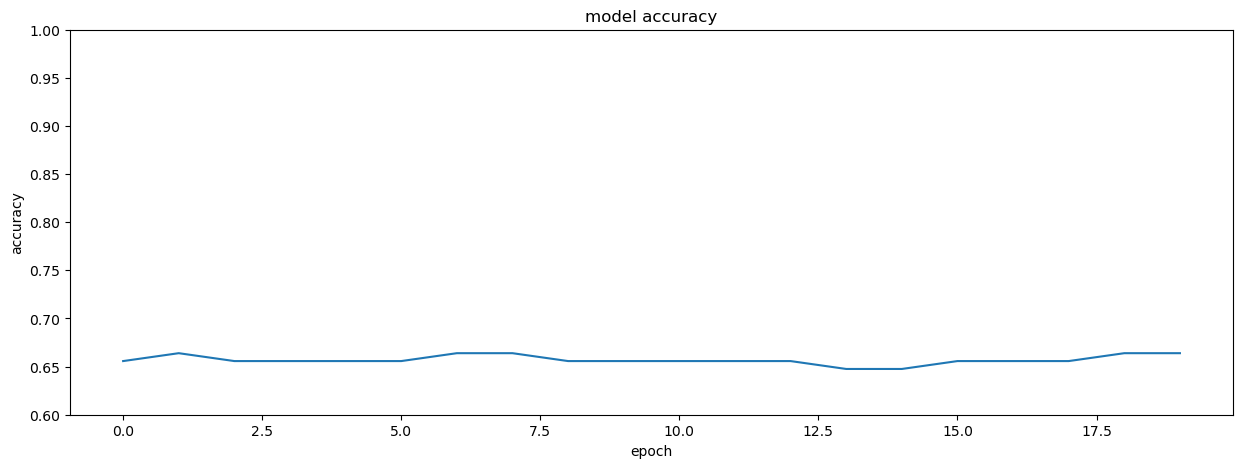

In [129]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.60,1])
plt.show()

# CNN - Sunset

In [19]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Sunset"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [ ]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs = 20, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('Sunset model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.60,1])
plt.show()

In [ ]:
Sunset_classifications = model.predict(test_images)

threshold = .5
Sunset_binary_classifications = (Sunset_classifications > threshold).astype(int)

Sunset_binary_classifications

# CNN - Flower

In [ ]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Flower"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [ ]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs = 20, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('Flower model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.60,1])
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('Flower model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.60,1])
plt.show()

In [ ]:
Flower_classifications = model.predict(test_images)

threshold = .5
Flower_binary_classifications = (Flower_classifications > threshold).astype(int)

Flower_binary_classifications

# CNN - Animal

In [ ]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Animal"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs = 20, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('Animal model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.60,1])
plt.show()

In [ ]:
Animal_classifications = model.predict(test_images)

threshold = .5
Animal_binary_classifications = (Animal_classifications > threshold).astype(int)

Animal_binary_classifications

# CNN - Building

In [ ]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Building"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs = 20, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('Building model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.60,1])
plt.show()

In [ ]:
Building_classifications = model.predict(test_images)

threshold = .5
Building_binary_classifications = (Building_classifications > threshold).astype(int)

Building_binary_classifications

# CNN - Mask



In [ ]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Building"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs = 20, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('Building model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.60,1])
plt.show()

In [ ]:
Mask_classifications = model.predict(test_images)

threshold = .5
Mask_binary_classifications = (Mask_classifications > threshold).astype(int)

Mask_binary_classifications

# CNN - Gray-Hair

In [ ]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Gray-Hair"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs = 20, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('Gray-hair model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.60,1])
plt.show()

In [ ]:
gray_classifications = model.predict(test_images)

threshold = .5
gray_binary_classifications = (gray_classifications > threshold).astype(int)

gray_binary_classifications

# CNN - Fire

In [ ]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Fire"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs = 20, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('Fire model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.60,1])
plt.show()

In [ ]:
fire_classifications = model.predict(test_images)

threshold = .5
fire_binary_classifications = (fire_classifications > threshold).astype(int)

fire_binary_classifications

# CNN - Food_drink

In [ ]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Food_drink"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs = 20, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('Food_drink model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.60,1])
plt.show()

In [ ]:
food_classifications = model.predict(test_images)

threshold = .5
food_binary_classifications = (food_classifications > threshold).astype(int)

food_binary_classifications

# Combined Final Model